# Structural similarity

In [116]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs

In [117]:
# let's define the Tanimoto similarity for ourselves:

def tanimoto(vector1, vector2):
    set_bits = 0
    shared_bits = 0
    for bit1, bit2 in zip(vector1, vector2):
        if bit1 or bit2: # at least one vector has this feature
            set_bits += 1
            if bit1 and bit2: # both vectors have this feature
                shared_bits += 1
    return shared_bits / set_bits

In [118]:
with open('Epidermal_growth_factor_receptor_erbB1_IC50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    EGFR_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

RDKit ERROR: [15:24:49] ERROR: Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [18:34:23] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: bad size
RDKit ERROR: Violation occurred on line 707 in file /opt/conda/conda-bld/rdkit_1603173682698/work/Code/GraphMol/MolDraw2D/MolDraw2D.cpp
RDKit ERROR: Failed Expression: !legends || legends->size() == mols.size()
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [18:37:09] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:37:09] ERROR: Could not sanitize molecule ending on line 20009
RDKit ERROR: [18:37:09] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:37:09] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [18:37:09] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [18:37:09] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [

In [119]:
def similarity_search(query_fp, searched_fp_set, cutoff=0.8):
    # we have no index, so we will have to just iterate through the entire searched set
    hits = []
    for i, fp in enumerate(searched_fp_set):
        similarity = DataStructs.TanimotoSimilarity(query_fp, fp)
        if similarity >= cutoff: # similar enough for consideration
            hits.append((i, similarity))
    return sorted(hits, key=lambda x: x[1], reverse=True) # stronger hits first

In [120]:
EGFR_ligands_maccs = [MACCSkeys.GenMACCSKeys(m) for m in EGFR_ligands]
drugs_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugs]

hits = similarity_search(EGFR_ligands_maccs[2307], drugs_maccs)
hits

[(218, 1.0), (5831, 0.96)]

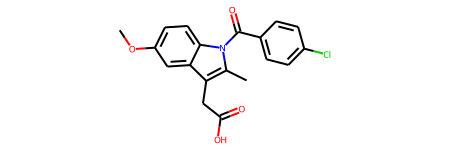

In [121]:
EGFR_ligands[2307]  # my query structure

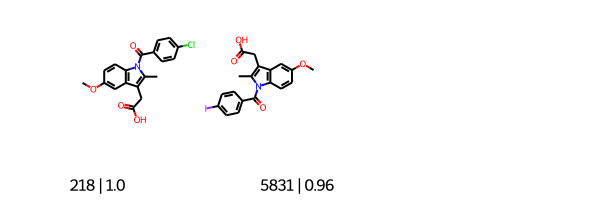

In [122]:
# the hits among Drugbank using MACCS keys
Draw.MolsToGridImage([drugs[hit[0]] for hit in hits], legends=["{} | {}".format(hit[0], hit[1]) for hit in hits])

Similarity search of a random EGFR ligand with id 2307 through DrugBank structures with the default cutoff 0.8 for Tanimoto similarity has given 2 structures: one as an exact match (tanimoto 1.0) and the other as quite similar structure (tanimoto 0.96).

Let's do the same exact query, but using ECFP instead of MACCS:

In [123]:
EGFR_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in EGFR_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
              for m in drugs]

In [124]:
hits = similarity_search(EGFR_ligands_ecfp[2307], drugs_ecfp)
hits

[(218, 1.0), (5831, 0.8)]

Because the hits among Drugbank using MACCS keys were quite accurate, we got hits using ECFP too.

Let's search for all our ligands among the DrugBank database, to see how close we are to the known drugs:

In [125]:
EGFR_ligands_queries = [(i, similarity_search(ligand_ecfp, drugs_ecfp))
                     for i, ligand_ecfp in enumerate(EGFR_ligands_ecfp)]

In [126]:
# only take ligands that actually matched something in DrugBank
EGFR_ligand_hits = [hit for hit in EGFR_ligands_queries if hit[1]]
EGFR_ligand_hits

[(26, [(1132, 0.8292682926829268)]),
 (33, [(6293, 0.8333333333333334)]),
 (42, [(207, 0.8709677419354839)]),
 (43, [(7020, 0.8461538461538461)]),
 (52, [(7020, 0.8333333333333334)]),
 (62, [(1603, 1.0), (1890, 1.0), (3873, 1.0)]),
 (68, [(415, 1.0)]),
 (76, [(1429, 1.0)]),
 (85, [(7020, 0.8571428571428571)]),
 (122, [(6692, 1.0)]),
 (154, [(1132, 1.0)]),
 (155, [(5524, 1.0)]),
 (166, [(207, 1.0)]),
 (167, [(5524, 1.0)]),
 (176, [(415, 1.0)]),
 (180, [(4450, 0.8412698412698413), (6585, 0.8412698412698413)]),
 (182, [(893, 1.0)]),
 (183, [(474, 1.0)]),
 (216, [(200, 1.0), (5892, 1.0)]),
 (225, [(207, 1.0)]),
 (245, [(4450, 1.0), (6585, 1.0)]),
 (269, [(7020, 1.0)]),
 (272, [(415, 1.0)]),
 (294, [(7020, 1.0)]),
 (297, [(7020, 1.0)]),
 (315, [(415, 1.0)]),
 (365, [(1429, 1.0)]),
 (378, [(1429, 1.0)]),
 (405, [(1132, 1.0)]),
 (429, [(203, 1.0)]),
 (446, [(1132, 1.0)]),
 (456, [(6802, 1.0)]),
 (460, [(1132, 1.0)]),
 (466, [(1755, 1.0)]),
 (477, [(4450, 1.0), (6585, 1.0)]),
 (494, [(207, 1.0

In [127]:
len(EGFR_ligands_queries), len(EGFR_ligand_hits)

(14362, 1534)

1534 of 14362 ligands appear to be significantly structurally similar to something in DrugBank.

In [128]:
EGFR_ligand_hits[15]

(180, [(4450, 0.8412698412698413), (6585, 0.8412698412698413)])

The EGFR ligand 180 hits DrugBank structure 4450 and 6585 on a high degree of similarity.

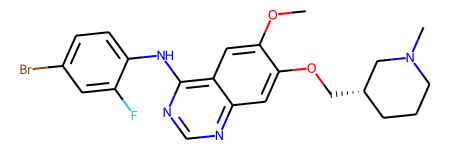

In [129]:
# The query structure
EGFR_ligands[EGFR_ligand_hits[15][0]]

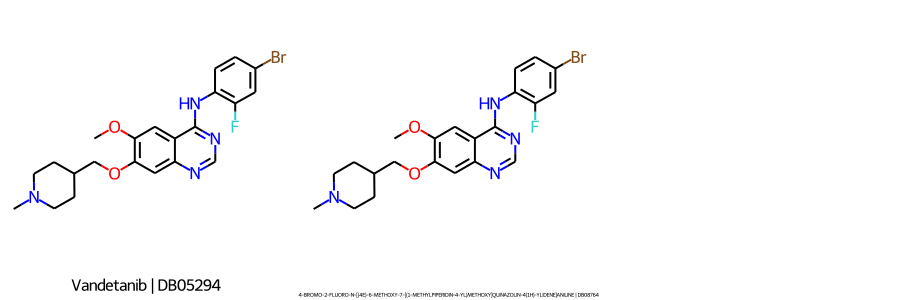

In [138]:
# And the DrugBank hits to that
hit_mols = [drugs[index] for index, similarity in EGFR_ligand_hits[15][1]]
Draw.MolsToGridImage(hit_mols, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in hit_mols])

In [140]:
drugs_hitcounts = {}
for ligand, hits in EGFR_ligand_hits:
    for hit, similarity in hits:
        drugs_hitcounts[hit] = drugs_hitcounts.get(hit, 0) + 1

In [141]:
ordered_drugs_hitcounts = sorted(drugs_hitcounts.keys(), key=lambda x: drugs_hitcounts[x], reverse=True)

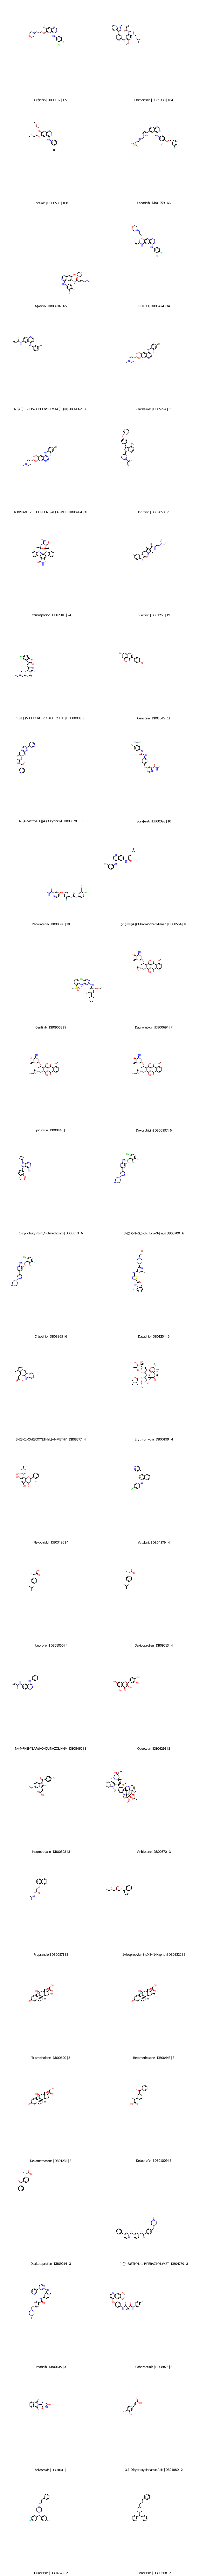

In [147]:
hit_mols = [drugs[i] for i in ordered_drugs_hitcounts]
Draw.MolsToGridImage(hit_mols, molsPerRow=2, subImgSize=(500,500),
                     legends=["{} | {} | {}".format(drugs[i].GetProp('GENERIC_NAME')[:30], # just cut off too long IUPAC stuff
                                                    drugs[i].GetProp('DRUGBANK_ID'),
                                                    drugs_hitcounts[i])
                              for i in ordered_drugs_hitcounts])

The most frequently hit substances in the DrugBank database are Gefitinib, Osimertinib, Erlotinib, Lapatinib, Afatinib, Vandetanib, Ibrutinib with 177, 164, 108, 66, 65, 34, 33 independent hits respectively. They are used as drugs for treating some types of cancer.

There are also substances that are used as antibiotics: Staurosporine, Daunorubicin, Epirubicin, Doxorubicin, Erythromycin; as nonsteroidal anti-inflammatory drug: Ibuprofen, Dexibuprofen, Dexketoprofenum, Indomethacin, Ketoprofen; as beta blocker: Propranolol; as corticosteroids: 
Triamcinolon, Betamethasone, Dexamethasone.

The infamous thalidomide is also present.

from wikipedia:

"Thalidomide was first marketed in 1957 in West Germany, where it was available over the counter. When first released, thalidomide was promoted for anxiety, trouble sleeping, "tension", and morning sickness. While it was initially thought to be safe in pregnancy, concerns regarding birth defects arose in 1961 and the medication was removed from the market in Europe that year.The total number of embryos affected by use during pregnancy is estimated at 10,000, of which about 40% died around the time of birth. Those who survived had limb, eye, urinary tract, and heart problems."



# Diversity picking

In [148]:
def distance_function(index1, index2, *args, fingerprints=EGFR_ligands_ecfp,
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [149]:
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(EGFR_ligands), 45))
picked

[6297,
 209,
 1207,
 5505,
 13732,
 10129,
 10678,
 7634,
 7122,
 7723,
 3886,
 4565,
 11882,
 9471,
 7732,
 11707,
 10400,
 1375,
 12726,
 12604,
 4839,
 2431,
 8413,
 4747,
 3939,
 2868,
 6385,
 9424,
 6389,
 5328,
 7038,
 3284,
 927,
 2336,
 6041,
 3339,
 11744,
 13835,
 3634,
 12872,
 10378,
 3884,
 8404,
 11482,
 742]

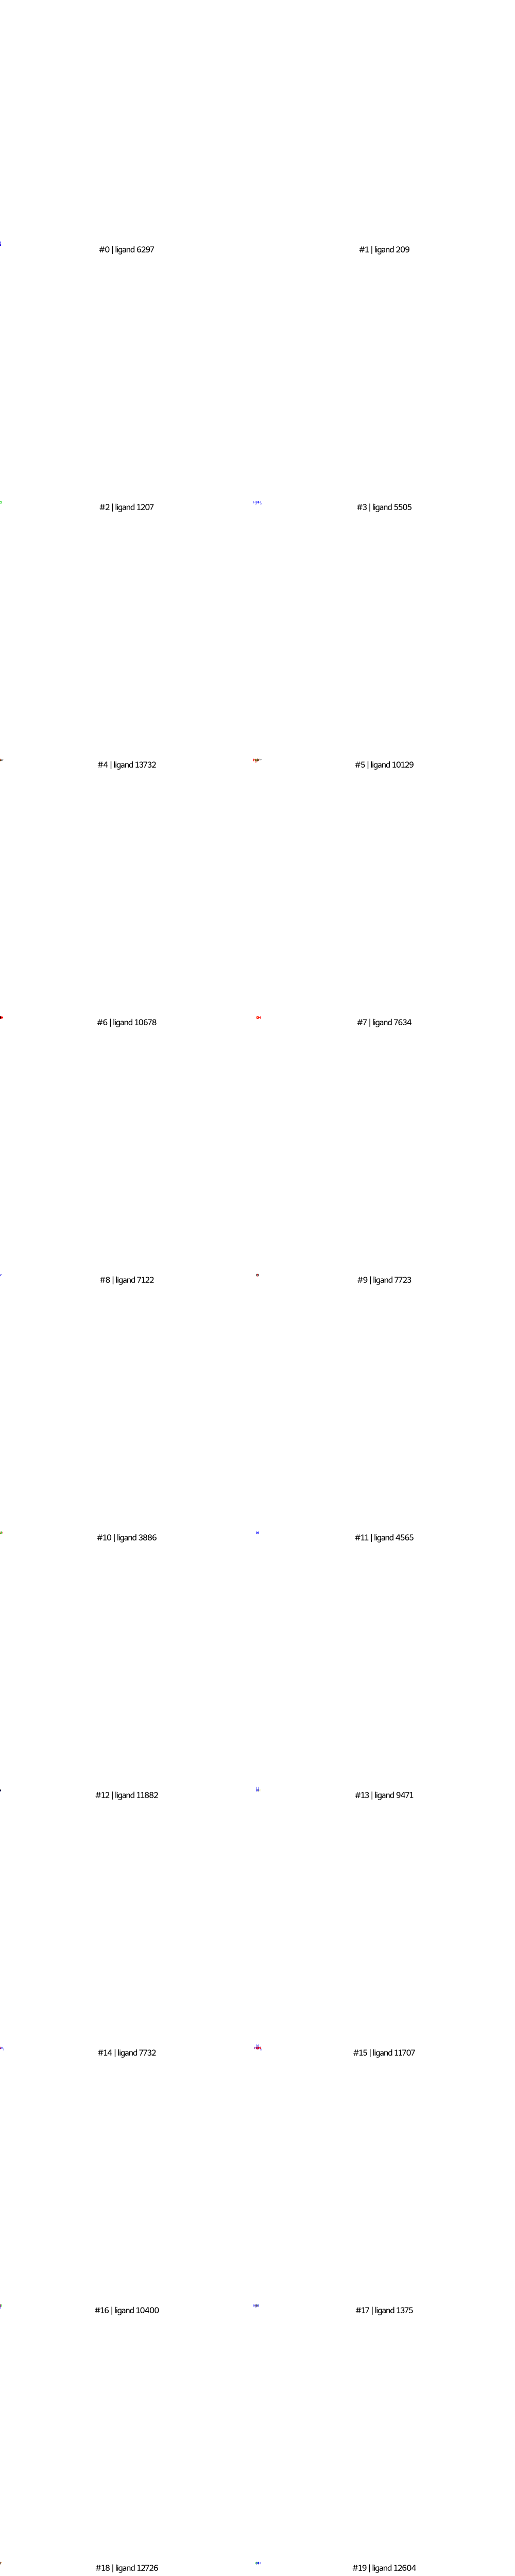

In [156]:
Draw.MolsToGridImage([EGFR_ligands[i] for i in picked[:20]], molsPerRow=2, subImgSize=(500,500),
                     legends=["#{} | ligand {}".format(i, hit) for i, hit in enumerate(picked)])